In [2]:
#changing here
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as smd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load and process the data

In [3]:
df = pd.read_csv('monthly_sales_new_run_volume.csv')

In [4]:
df['Month'] = pd.to_datetime(df['Month'])

In [5]:
df.head()

,Month,Volume,New Customers
0,2018-01-01,25297,4340
1,2018-02-01,19524,3585
2,2018-03-01,37639,6602
3,2018-04-01,47419,7517
4,2018-05-01,55242,8167


### The exogenous variable 'New_Users' is a count of purchases made each month by people who made their first purchase in the same year
#### The trial redeemers data doesn't cover the whole period, a separate model must be built with less data to be able to use the trial redeemers as the exogenous variable

In [6]:
y = pd.Series(data=df['Volume'].values, index=df['Month'])
#Create time series based on 'Month'

In [7]:
y.head()

Month
2018-01-01    25297
2018-02-01    19524
2018-03-01    37639
2018-04-01    47419
2018-05-01    55242
dtype: int64

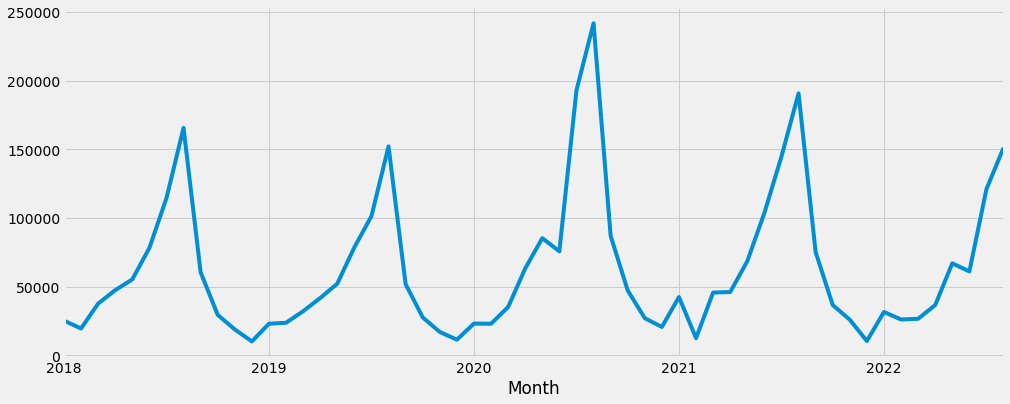

In [8]:
y.plot(figsize=(15, 6))
plt.show()

In [10]:
# create time series for the exogenous variable
exog1 = pd.Series(data=df['New Customers'].values, index=df['Month'])
exog1.head()

Month
2018-01-01    4340
2018-02-01    3585
2018-03-01    6602
2018-04-01    7517
2018-05-01    8167
dtype: int64

# ADF test to check stationarity of the data. SARIMAX models work best with stationary data

t-statistic             -0.874786
p-value                  0.796162
lags-used               11.000000
no-of-observations      44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
dtype: float64


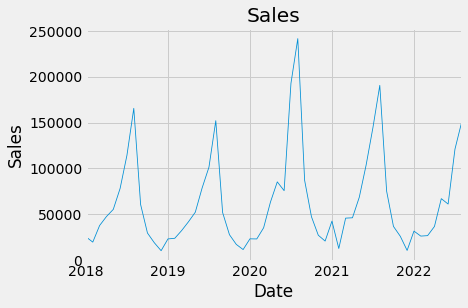

In [11]:
# Applying ADF Test:
ax = y.plot(linewidth = 0.8) 
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales')


nonst_test = smd.adfuller(y)

# Printing the results
output = pd.Series(nonst_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in nonst_test[4].items():
    output['Critical Value (%s)'%key] = value
  
print(output)

In [12]:
# Apply transformation to make data stationary:
log_data = np.log(y) # Taking the log
ma_data = log_data.rolling(window=12).mean() # Taking moving average
log_minus_ma_data = log_data - ma_data
log_minus_ma_data.dropna(inplace=True)

Text(0.5, 1.0, 'Sales')

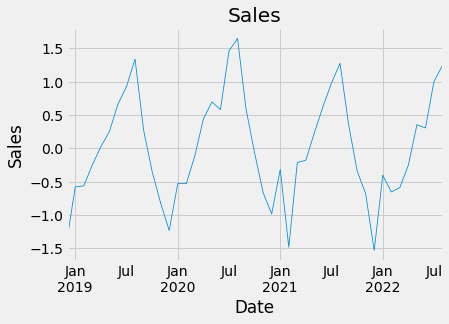

In [13]:
# Plotting the data 
ax = log_minus_ma_data.plot(linewidth = 0.8)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Sales')

In [14]:
# Applying ADF Test after applying transformations:
st_test = smd.adfuller(log_minus_ma_data)

# Printing the results:
output = pd.Series(st_test[0:4], index=['t-statistic','p-value','lags-used','no-of-observations'])
for key,value in st_test[4].items():
    output['Critical Value (%s)'%key] = value
  
print(output)

t-statistic             -4.704205
p-value                  0.000083
lags-used                7.000000
no-of-observations      37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


In [15]:
# Creating data frame with stationary data and exogenous variable
st = log_minus_ma_data.to_frame()
ex1 = exog1.to_frame()
data_df = pd.merge(st,ex1,on='Month')
data_df = data_df.set_axis(['sales','new_users'], axis='columns')
data_df.head()

,sales,new_users
Month,,
2018-12-01,-1.403667,3109
2019-01-01,-0.577719,3861
2019-02-01,-0.563301,4020
2019-03-01,-0.246966,4999
2019-04-01,0.025369,5334


# Grid search the p, d, q parameters

In [16]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Training model with stationary data and exogenous variable to find the best combination of p,d and q with a grid search. The Akaike information criterion (AIC) is used as the estimator of the prediction error.

In [17]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(log_minus_ma_data,
                                            order=param,
                                            exog=data_df.iloc[:,1:],
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))

            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
            
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 222.706108921031
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 1566.9822173047132
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 100.41114305963781
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 104.21207129040293
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 22.84960864539472
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 24.899717705010822
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 85.7373841289507
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 43.839791181343266
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 45.91894020300032
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 52.589002925742506
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 53.38884616176345
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 102.41114305963781
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 17.01277521752336
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 24.84960864539472
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 26.899717705010822
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 52.48935630277982
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 45.839791181343266
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 47.

ARIMA(0, 1, 2) x (1, 0, 2, 12) - AIC: 68.6316740235996
ARIMA(0, 1, 2) x (1, 1, 0, 12) - AIC: 42.424417083367146
ARIMA(0, 1, 2) x (1, 1, 1, 12) - AIC: 35.11858646470631
ARIMA(0, 1, 2) x (1, 1, 2, 12) - AIC: 37.11858646471252
ARIMA(0, 1, 2) x (1, 2, 0, 12) - AIC: 50.818065847224155
ARIMA(0, 1, 2) x (1, 2, 1, 12) - AIC: 52.818066008888714
ARIMA(0, 1, 2) x (1, 2, 2, 12) - AIC: 54.818066008889076
ARIMA(0, 1, 2) x (2, 0, 0, 12) - AIC: 79.90299686600643
ARIMA(0, 1, 2) x (2, 0, 1, 12) - AIC: 1752.4885774034167
ARIMA(0, 1, 2) x (2, 0, 2, 12) - AIC: 70.63167411021098
ARIMA(0, 1, 2) x (2, 1, 0, 12) - AIC: 36.78992275568518
ARIMA(0, 1, 2) x (2, 1, 1, 12) - AIC: 37.118586464712486
ARIMA(0, 1, 2) x (2, 1, 2, 12) - AIC: 39.1185864647187
ARIMA(0, 1, 2) x (2, 2, 0, 12) - AIC: 52.81806584722438
ARIMA(0, 1, 2) x (2, 2, 1, 12) - AIC: 54.818066008888366
ARIMA(0, 1, 2) x (2, 2, 2, 12) - AIC: 56.818066008887314
ARIMA(0, 2, 0) x (0, 0, 0, 12) - AIC: 216.70311895961095
ARIMA(0, 2, 0) x (0, 0, 1, 12) - AIC: 163

ARIMA(1, 0, 1) x (2, 1, 1, 12) - AIC: 117.77665711188692
ARIMA(1, 0, 1) x (2, 1, 2, 12) - AIC: 119.77665711188692
ARIMA(1, 0, 1) x (2, 2, 0, 12) - AIC: 68.37345714281726
ARIMA(1, 0, 1) x (2, 2, 1, 12) - AIC: 70.37345714281726
ARIMA(1, 0, 1) x (2, 2, 2, 12) - AIC: 72.37345714281726
ARIMA(1, 0, 2) x (0, 0, 0, 12) - AIC: 60.96429639154511
ARIMA(1, 0, 2) x (0, 0, 1, 12) - AIC: 2039.6797794641225
ARIMA(1, 0, 2) x (0, 0, 2, 12) - AIC: 64.9642963915451
ARIMA(1, 0, 2) x (0, 1, 0, 12) - AIC: 27.85666711182857
ARIMA(1, 0, 2) x (0, 1, 1, 12) - AIC: 29.85666711846162
ARIMA(1, 0, 2) x (0, 1, 2, 12) - AIC: 31.856667118541836
ARIMA(1, 0, 2) x (0, 2, 0, 12) - AIC: 48.08489419940377
ARIMA(1, 0, 2) x (0, 2, 1, 12) - AIC: 50.084894199360704
ARIMA(1, 0, 2) x (0, 2, 2, 12) - AIC: 52.08489419936071
ARIMA(1, 0, 2) x (1, 0, 0, 12) - AIC: 61.82355946052823
ARIMA(1, 0, 2) x (1, 0, 1, 12) - AIC: 67.81834903119717
ARIMA(1, 0, 2) x (1, 0, 2, 12) - AIC: 66.9642963915451
ARIMA(1, 0, 2) x (1, 1, 0, 12) - AIC: 26.2869

ARIMA(1, 2, 1) x (0, 2, 1, 12) - AIC: 63.462581830095175
ARIMA(1, 2, 1) x (0, 2, 2, 12) - AIC: 65.46258182997276
ARIMA(1, 2, 1) x (1, 0, 0, 12) - AIC: 71.82690439203344
ARIMA(1, 2, 1) x (1, 0, 1, 12) - AIC: 1684.947927533202
ARIMA(1, 2, 1) x (1, 0, 2, 12) - AIC: 77.42887216476507
ARIMA(1, 2, 1) x (1, 1, 0, 12) - AIC: 65.06064262955508
ARIMA(1, 2, 1) x (1, 1, 1, 12) - AIC: 56.03790007606081
ARIMA(1, 2, 1) x (1, 1, 2, 12) - AIC: 58.037900164436515
ARIMA(1, 2, 1) x (1, 2, 0, 12) - AIC: 63.46258182705731
ARIMA(1, 2, 1) x (1, 2, 1, 12) - AIC: 65.4625851571038
ARIMA(1, 2, 1) x (1, 2, 2, 12) - AIC: 67.46258515698706
ARIMA(1, 2, 1) x (2, 0, 0, 12) - AIC: 75.4288720768426
ARIMA(1, 2, 1) x (2, 0, 1, 12) - AIC: 1040.9532043329004
ARIMA(1, 2, 1) x (2, 0, 2, 12) - AIC: 79.4288721642335
ARIMA(1, 2, 1) x (2, 1, 0, 12) - AIC: 56.037860998765126
ARIMA(1, 2, 1) x (2, 1, 1, 12) - AIC: 58.03790016306508
ARIMA(1, 2, 1) x (2, 1, 2, 12) - AIC: 60.0379002469003
ARIMA(1, 2, 1) x (2, 2, 0, 12) - AIC: 65.4625818

ARIMA(2, 1, 0) x (2, 0, 0, 12) - AIC: 78.51912413910884
ARIMA(2, 1, 0) x (2, 0, 1, 12) - AIC: 2022.2125979063687
ARIMA(2, 1, 0) x (2, 0, 2, 12) - AIC: 71.67817943024073
ARIMA(2, 1, 0) x (2, 1, 0, 12) - AIC: 34.136785682012544
ARIMA(2, 1, 0) x (2, 1, 1, 12) - AIC: 34.423231234462946
ARIMA(2, 1, 0) x (2, 1, 2, 12) - AIC: 36.423231234453446
ARIMA(2, 1, 0) x (2, 2, 0, 12) - AIC: 52.11447311311587
ARIMA(2, 1, 0) x (2, 2, 1, 12) - AIC: 54.1144730755294
ARIMA(2, 1, 0) x (2, 2, 2, 12) - AIC: 56.114473076856825
ARIMA(2, 1, 1) x (0, 0, 0, 12) - AIC: 65.79526795089626
ARIMA(2, 1, 1) x (0, 0, 1, 12) - AIC: 1897.4778409977396
ARIMA(2, 1, 1) x (0, 0, 2, 12) - AIC: 69.79526794851358
ARIMA(2, 1, 1) x (0, 1, 0, 12) - AIC: 30.286503419698338
ARIMA(2, 1, 1) x (0, 1, 1, 12) - AIC: 32.28650345130322
ARIMA(2, 1, 1) x (0, 1, 2, 12) - AIC: 34.286503452050624
ARIMA(2, 1, 1) x (0, 2, 0, 12) - AIC: 48.93972014270141
ARIMA(2, 1, 1) x (0, 2, 1, 12) - AIC: 50.939720143578334
ARIMA(2, 1, 1) x (0, 2, 2, 12) - AIC: 52

# Plot model diagnostics

In [18]:
#we use the best result for p,d and q
mod = sm.tsa.statespace.SARIMAX(log_minus_ma_data,
                                order=(best_result[0][0], best_result[0][1], best_result[0][1]),
                                #freq='M',
                                exog=data_df.iloc[:,1:],
                                seasonal_order=(best_result[1][0], best_result[1][1], best_result[1][2], best_result[1][3]),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
new_users   7.691e-06   5.61e-06      1.370      0.171   -3.31e-06    1.87e-05
ar.S.L12      -0.6738      0.186     -3.618      0.000      -1.039      -0.309
sigma2         0.0856      0.018      4.890      0.000       0.051       0.120


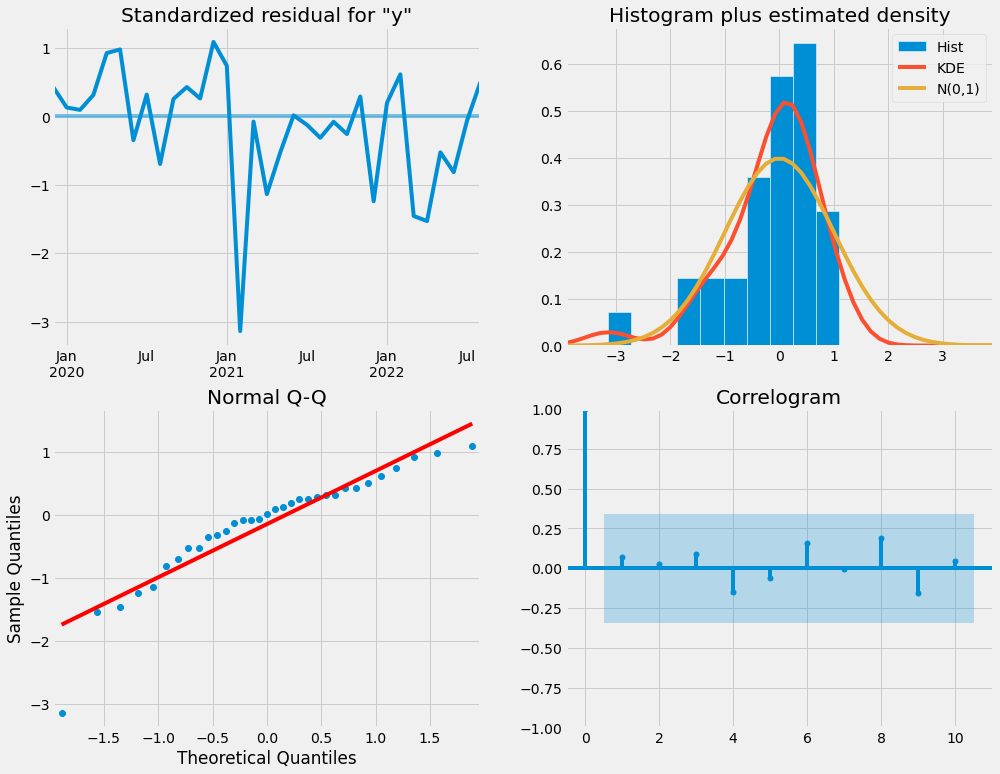

In [19]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Plot one-step ahead forecast

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_ci = pred.conf_int()

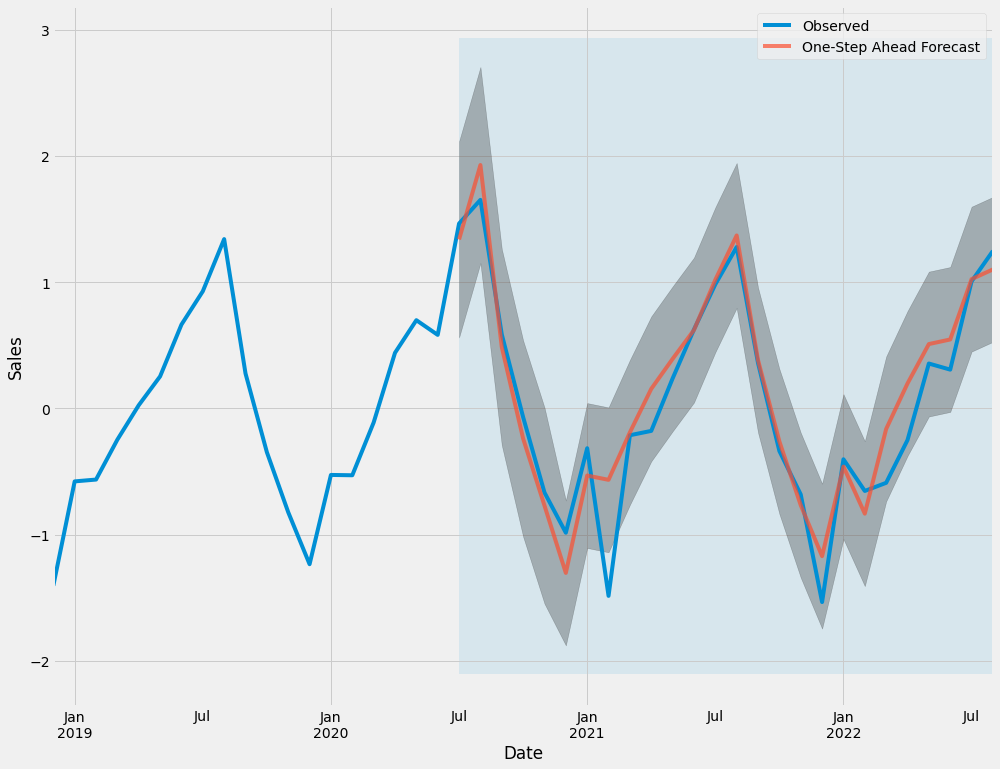

In [21]:
ax = log_minus_ma_data['2018':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-07-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

# Plot dynamic forecast

In [22]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

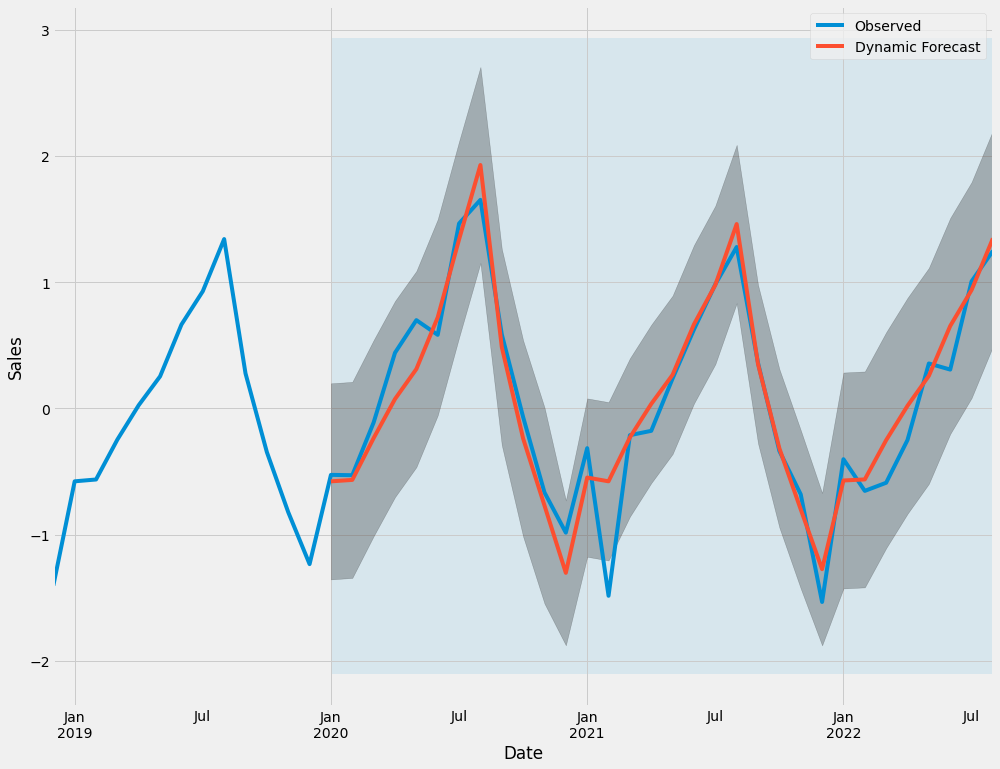

In [23]:
ax = log_minus_ma_data['2018':].plot(label='Observed', figsize=(15, 12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

In [24]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = log_minus_ma_data['2022-08-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


# Plot 2-year forecast

### The exog variable future values were adjusted based on the YTD trend through August 2022, compared vs the previous year.

In [25]:
exog_pred = pd.read_csv('exog_pred.csv')
exog_pred['Month'] = pd.to_datetime(exog_pred['Month'])
exog_pred_series = pd.Series(data=exog_pred['New_Users'].values, index=exog_pred['Month'])
#print(exog_pred_series)

In [26]:
# Get forecast 28 steps ahead in future
pred_uc = results.get_forecast(steps=28, exog=exog_pred_series)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

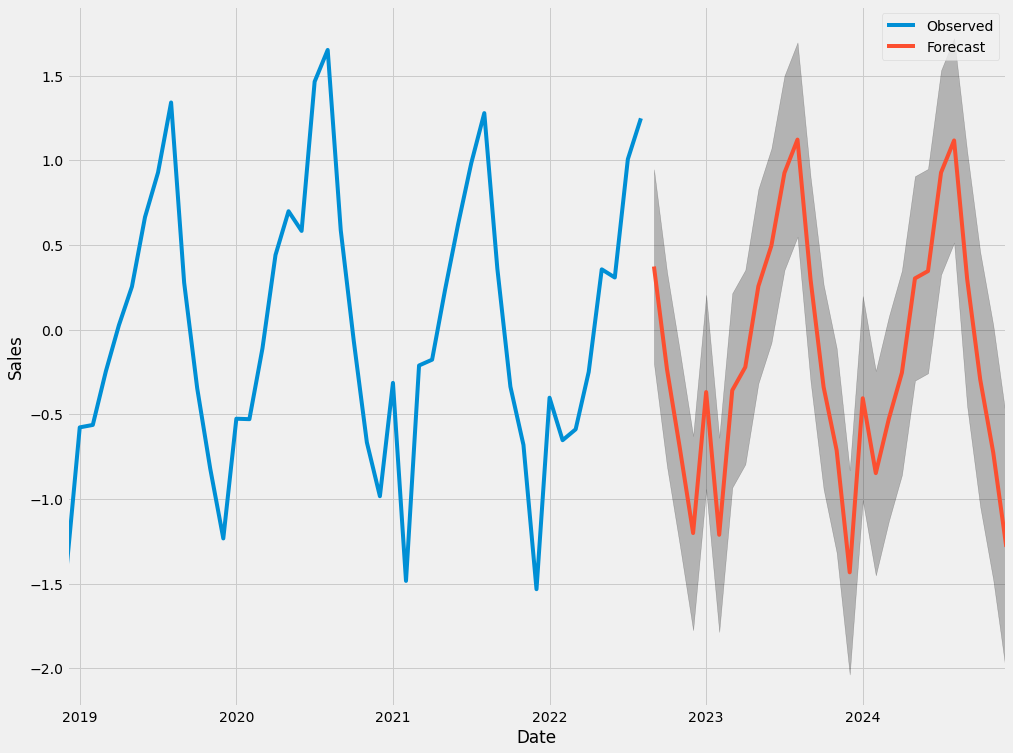

In [27]:
ax = log_minus_ma_data.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

# Export results

In [ ]:
np.exp(predictions_ARIMA_log).to_csv(r'predictions.csv', index = True, header=True)

In [28]:
pred_uc.predicted_mean.to_csv (r'predicted_means_exogVolume.csv', index = True, header=True)

In [ ]:
pred_ci.iloc[:, 0].to_csv (r'Abeka_all_ci_l_exog3.csv', index = True, header=True)

In [ ]:
pred_ci.iloc[:, 1].to_csv (r'Abeka_all_ci_h_exog3.csv', index = True, header=True)

In [29]:
log_minus_ma_data.to_csv (r'log_minus_ma_data_exogVolume.csv', index = True, header=True)

In [30]:
ma_data.to_csv (r'ma_data_exogVolume.csv', index = True, header=True)

In [31]:
log_data.to_csv (r'log_data_exogVolume.csv', index = True, header=True)

In [ ]:
pred_dynamic.predicted_mean.to_csv (r'pred_dynamic_exog3.csv', index = True, header=True)